In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import cmath

def permittivity_to_refractive_index(epsilon):
    """
    복소 유전율(epsilon)을 입력받아 복소 굴절률(n + i*k)을 반환합니다.
    epsilon: 복소수 혹은 실수 형태의 유전율(예: 2.13, -7.01+0.21j 등)
    return: 복소 굴절률 n_complex = n + i*k (n_complex.real, n_complex.imag)
    """
    return cmath.sqrt(epsilon)

# 예시: 표에 주어진 물질들의 복소 유전율
materials = {
    "SiO2": 2.13,             # 실수만 있는 경우
    "Ag"  : -7.01 + 0.21j,    # 복소수(실수부가 음수)
    "GaN" : 6.18,             # 실수만 있는 경우
    "Al2O3": 3.17             # 실수만 있는 경우
}

# 각 물질에 대해 복소 굴절률 계산
for mat, eps in materials.items():
    n_complex = permittivity_to_refractive_index(eps)
    n = n_complex.real  # 실수부
    k = n_complex.imag  # 허수부
    print(f"{mat} (ε={eps}): n = {n:.3f}, k = {k:.3f}")


SiO2 (ε=2.13): n = 1.459, k = 0.000
Ag (ε=(-7.01+0.21j)): n = 0.040, k = 2.648
GaN (ε=6.18): n = 2.486, k = 0.000
Al2O3 (ε=3.17): n = 1.780, k = 0.000


In [117]:
resolution = 200
nm = 1e-3

wavelength = 450*nm # um
fcen = 1/wavelength # um
df = 0.1

al2o3_str_x = 100*nm
al2o3_str_y = 1070*nm

ag_str_x = 1000*nm
ag_str_y = 70*nm

sio2_str_x = 70*nm
sio2_str_y = 1070*nm

gan_str_x = 1000*nm
gan_str_y = 1000*nm

In [118]:
# 재료 정의(Ag의 경우는 음의 굴절률을 가지기 때문에 conductivity로 변환)
GaN = mp.Medium(epsilon=2.486)  # GaN
# Qw = mp.Medium(epsilon=)  # QW (양자 우물, GaN과 비슷하게 설정)
Ag = mp.Medium(epsilon=-7.01, D_conductivity=2*np.pi*wavelength*0.101/7.01)
SiO2 = mp.Medium(epsilon=1.459)  # SiO2
Al2O3 = mp.Medium(epsilon=1.78)  # Al2O3

In [119]:
# 전체 구조 크기
structure_x = ag_str_x + 2*sio2_str_x + 2*al2o3_str_x   # 1340 nm
structure_y = al2o3_str_y + wavelength*1.5              # 1070 nm
structure_size = mp.Vector3(structure_x, structure_y, 0)

# 왼쪽 끝 ~ 오른쪽 끝을 -structure_x/2 ~ +structure_x/2로 놓고,
# 각 블록이 이어지도록 x 좌표를 순차적으로 계산
left_edge = -0.5 * structure_x  # 왼쪽 끝 x좌표 = -670 nm

# (1) 왼쪽 Al2O3
al2o3_left_center = left_edge + 0.5*al2o3_str_x  # -670 + 50 = -620 nm

# (2) 왼쪽 SiO2
sio2_left_center  = al2o3_left_center + 0.5*al2o3_str_x + 0.5*sio2_str_x
#  = -620 + 50 + 35 = -535 nm

# (3) 중앙 GaN
gan_center = sio2_left_center + 0.5*sio2_str_x + 0.5*gan_str_x
#  = -535 + 35 + 500 = 0 nm

# (4) 오른쪽 SiO2
sio2_right_center = gan_center + 0.5*gan_str_x + 0.5*sio2_str_x
#  = 0 + 500 + 35 = 535 nm

# (5) 오른쪽 Al2O3
al2o3_right_center = sio2_right_center + 0.5*sio2_str_x + 0.5*al2o3_str_x
#  = 535 + 35 + 50 = 620 nm

# 이제 geometry 리스트 구성
geometry = [
    # 왼쪽 Al2O3
    mp.Block(size=mp.Vector3(al2o3_str_x, al2o3_str_y, mp.inf),
             center=mp.Vector3(al2o3_left_center, 0),
             material=Al2O3),  # 예시로 index 지정
    
    # 왼쪽 SiO2
    mp.Block(size=mp.Vector3(sio2_str_x, sio2_str_y, mp.inf),
             center=mp.Vector3(sio2_left_center, 0),
             material=SiO2),  # 예시로 index 지정
    
    # 중앙 GaN
    mp.Block(size=mp.Vector3(gan_str_x, gan_str_y, mp.inf),
             center=mp.Vector3(gan_center, 35*nm),
             material=GaN),   # 예시로 index 지정
    
    # # QW (예: 두께 20 nm, 중앙에서 y=-480 nm 위치)
    # mp.Block(size=mp.Vector3(gan_str_x, 20*nm, mp.inf),
    #          center=mp.Vector3(gan_center, -480*nm),
    #          material=mp.Medium(index=3.0)),   # 예시로 index 지정
    
    # 오른쪽 SiO2
    mp.Block(size=mp.Vector3(sio2_str_x, sio2_str_y, mp.inf),
             center=mp.Vector3(sio2_right_center, 0),
             material=SiO2),
    
    # 오른쪽 Al2O3
    mp.Block(size=mp.Vector3(al2o3_str_x, al2o3_str_y, mp.inf),
             center=mp.Vector3(al2o3_right_center, 0),
             material=Al2O3),
    
    # 맨 아래 Ag (두께 70 nm, 전체 너비 1000 nm)
    mp.Block(size=mp.Vector3(ag_str_x, ag_str_y, mp.inf),
             center=mp.Vector3(0, - (0.5*structure_y - 0.5*ag_str_y)+ wavelength*0.75),
             material=Ag)  # 예시로 Ag 복소 굴절률
]

In [120]:
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=0.1*fcen),
        component=mp.Ez,
        center=mp.Vector3(0, 0)  # QW 중앙에 배치
    )
]

pml_layer = [mp.PML(70*nm)]

In [123]:
fr = mp.FluxRegion(
    center = mp.Vector3(0,al2o3_str_y/2+wavelength,0), size = mp.Vector3(al2o3_str_x*2+sio2_str_x*2+ag_str_x)
)
nfreq = 100

     block, center = (-0.62,0,0)
          size (0.1,1.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.78,1.78,1.78)
     block

, center = (-0.535,0,0)
          size (0.07,1.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.459,1.459,1.459)
     block, center = (1.11022e-16,0.035,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.486,2.486,2.486)
     block, center = (0.535,0,0)
          size (0.07,1.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.459,1.459,1.459)
     block, center = (0.62,0,0)
          size (0.1,1.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.78,1.78,1.78)
     block, center = (0,-0.5,0)
          size (1,0.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-7.01,-7.01,-7.01)


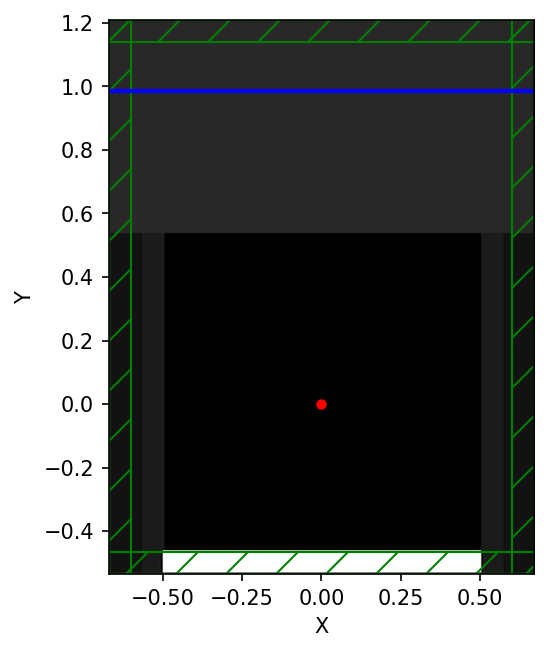

In [126]:
sim = mp.Simulation(
    cell_size=structure_size, 
    geometry_center= mp.Vector3(0,wavelength*0.75,0),
    boundary_layers=pml_layer,
    geometry=geometry,
    default_material = mp.Medium(index = 1),
    sources = sources,
    resolution=resolution
)
sim.add_flux(fcen, df, nfreq, fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

In [ ]:
design_resolution = 100
design_x = 
design_y = 